<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/Transformer(5_Labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# -*- coding: utf-8 -*-
# Transformer for Crop Production Classification

# This script demonstrates how to build and train a Transformer model
# for classifying crop production levels based on tabular data using TensorFlow/Keras.

## 1. Setup and Imports

# Import necessary libraries.
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score # Added f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive (optional, if data is stored there)
# from google.colab import drive
# drive.mount("/content/drive")

# Define file paths (adjust if using Google Drive or local upload)
# Example for uploaded files in Colab:
TRAIN_PATH = "/content/drive/MyDrive/UpdatedDataset/train.csv"
VALID_PATH = "/content/drive/MyDrive/UpdatedDataset/validation.csv"
TEST_PATH = "/content/drive/MyDrive/UpdatedDataset/test.csv"

# Example for Google Drive:
# DRIVE_PATH = "/content/drive/MyDrive/your_folder/"
# TRAIN_PATH = DRIVE_PATH + "train.csv"
# VALID_PATH = DRIVE_PATH + "validation.csv"
# TEST_PATH = DRIVE_PATH + "test.csv"


In [20]:

## 2. Load and Preprocess Data

# Load the datasets and apply preprocessing steps.
def load_and_preprocess(file_path, scaler=None, fit_scaler=False, label_encoder=None, fit_encoder=False):
    """Loads data, preprocesses features, and converts target to classes."""
    df = pd.read_csv(file_path)

    # Define class boundaries based on quantiles (5 classes)
    # Calculate quantiles on training data only (to avoid data leakage)
    if fit_scaler:  # Only calculate quantiles for training data
        global quantile_bins
        quantiles = df["Production (M.Ton)"].quantile([0.2, 0.4, 0.6, 0.8]).values
        quantile_bins = [-np.inf] + quantiles.tolist() + [np.inf]
        print(f"Quantile boundaries: {quantile_bins}")

    bins = quantile_bins
    labels = [0, 1, 2, 3, 4] # Very Low, Low, Medium, High, Very High

    # Convert target variable to classes
    df["Production_Class"] = pd.cut(df["Production (M.Ton)"], bins=bins, labels=labels, right=True)

    # Separate features and target
    X = df.drop(["Production (M.Ton)", "Production_Class"], axis=1)
    y = df["Production_Class"]

    # Identify numerical features (excluding one-hot encoded Crop and District)
    # Assuming columns starting with 'Crop_' or 'District_' are one-hot encoded
    numerical_cols = [col for col in X.columns if not col.startswith("Crop_") and not col.startswith("District_")]

    # Scale numerical features
    if fit_scaler:
        scaler = StandardScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else:
        if scaler is None:
            raise ValueError("Scaler must be provided if fit_scaler is False")
        X[numerical_cols] = scaler.transform(X[numerical_cols])

    # Encode labels
    if fit_encoder:
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
    else:
        if label_encoder is None:
            raise ValueError("LabelEncoder must be provided if fit_encoder is False")
        y_encoded = label_encoder.transform(y)

    # Convert labels to one-hot encoding
    y_one_hot = tf.keras.utils.to_categorical(y_encoded, num_classes=len(labels))

    # Return features as a flat numpy array (samples, features)
    X_flat = X.values

    if fit_scaler and fit_encoder:
        return X_flat, y_one_hot, scaler, label_encoder
    elif fit_scaler:
         return X_flat, y_one_hot, scaler
    elif fit_encoder:
        return X_flat, y_one_hot, label_encoder
    else:
        return X_flat, y_one_hot

# Initialize global variable for quantile bins
quantile_bins = None

# Load and preprocess data
print("Loading and preprocessing training data...")
X_train, y_train, scaler, label_encoder = load_and_preprocess(TRAIN_PATH, fit_scaler=True, fit_encoder=True)
print("Loading and preprocessing validation data...")
X_val, y_val = load_and_preprocess(VALID_PATH, scaler=scaler, label_encoder=label_encoder)
print("Loading and preprocessing test data...")
X_test, y_test = load_and_preprocess(TEST_PATH, scaler=scaler, label_encoder=label_encoder)

print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")
print(f"Number of classes: {y_train.shape[1]}")


Loading and preprocessing training data...
Quantile boundaries: [-inf, 578.0, 1463.0, 3119.5239999999994, 6540.920000000002, inf]
Loading and preprocessing validation data...
Loading and preprocessing test data...
Training data shape: (3942, 83), Labels shape: (3942, 5)
Validation data shape: (845, 83), Labels shape: (845, 5)
Test data shape: (845, 83), Labels shape: (845, 5)
Number of classes: 5


In [21]:

## 3. Build the Transformer Model

# Define the Transformer block as a layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    # Corrected call method: pass 'training' argument to sub-layers
    def call(self, inputs, training=None): # Allow training=None for inference
        # Pass training argument to MultiHeadAttention
        attn_output = self.att(inputs, inputs, training=training)
        # Pass training argument to Dropout 1
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        # Pass training argument to the Sequential FFN
        ffn_output = self.ffn(out1, training=training)
        # Pass training argument to Dropout 2
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the Transformer model building function
def build_transformer_model(input_shape, embed_dim, num_heads, ff_dim, num_transformer_blocks, num_classes, dropout_rate=0.1):
    """Builds the Transformer model for tabular data."""
    num_features = input_shape[0]
    inputs = keras.Input(shape=input_shape)

    # --- Feature Embedding and Positional Encoding ---
    # Project features to embedding dimension
    x = layers.Dense(num_features * embed_dim, activation='relu')(inputs) # Project
    x = layers.Reshape((num_features, embed_dim))(x) # Reshape to (batch, seq_len=num_features, embed_dim)

    # Add learnable positional embedding
    position_embedding_layer = layers.Embedding(input_dim=num_features, output_dim=embed_dim)
    positions = tf.range(start=0, limit=num_features, delta=1)
    position_embeddings = position_embedding_layer(positions)
    x = x + position_embeddings
    # Pass training argument to Dropout after embedding
    x = layers.Dropout(dropout_rate)(x) # Keras handles training arg here implicitly in functional API
    # ----------------------------------------------------

    # --- Transformer Blocks ---
    for _ in range(num_transformer_blocks):
        # Keras handles passing the 'training' context implicitly here in functional API
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)
    # -------------------------

    # --- Classifier Head ---
    x = layers.GlobalAveragePooling1D()(x) # Pool across the feature dimension
    # Pass training argument to Dropout layers
    x = layers.Dropout(0.1)(x) # Keras handles training arg here implicitly
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x) # Keras handles training arg here implicitly
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    # -----------------------

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# --- Hyperparameters ---
EMBED_DIM = 32  # Embedding dimension for each feature position
NUM_HEADS = 4   # Number of attention heads
FF_DIM = 32     # Hidden layer size in feed forward network inside transformer
NUM_TRANSFORMER_BLOCKS = 2 # Number of transformer blocks
DROPOUT_RATE = 0.1
# -----------------------

# Get input shape and number of classes from preprocessed data
input_shape = (X_train.shape[1],) # Shape is (num_features,)
num_classes = y_train.shape[1]

# Build the model
model = build_transformer_model(
    input_shape,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE
)

# Compile the model
# Consider using AdamW or a lower learning rate for Transformers
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Print model summary
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 83)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2656)           │       223,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 83, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_2 (Add)                     │ (None, 83, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 83, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ (None, 83, 32)         │        19,040 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ (None, 83, 32)         │        19,040 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,621 (1.01 MB)

 Trainable params: 263,621 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:

## 4. Train the Model

# Train the Transformer using the training and validation datasets.

# Define training parameters
EPOCHS = 100 # Transformers might need more epochs, adjust as needed
BATCH_SIZE = 64

# Add Early Stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True) # Increased patience

# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 207ms/step - accuracy: 0.2358 - loss: 1.5967 - val_accuracy: 0.3243 - val_loss: 1.5194
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 176ms/step - accuracy: 0.3427 - loss: 1.5071 - val_accuracy: 0.4118 - val_loss: 1.3804
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 205ms/step - accuracy: 0.4238 - loss: 1.3545 - val_accuracy: 0.5030 - val_loss: 1.2052
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.5364 - loss: 1.1698 - val_accuracy: 0.6118 - val_loss: 1.0240
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 181ms/step - accuracy: 0.6047 - loss: 1.0030 - val_accuracy: 0.6509 - val_loss: 0.9051
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step - accuracy: 0.6594 - loss: 0.8732 - val_accuracy: 0.6663 - val_loss: 0.8253
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.6924 - loss: 0.7825 - val_accuracy: 0.6663 - val_loss: 0.7921
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.7046 - loss: 0.7218 - 

In [23]:

## 5. Evaluate the Model

# Get best validation accuracy from history
# Check if 'val_accuracy' exists in history (it should if validation_data is provided)
if 'val_accuracy' in history.history:
    best_val_accuracy = max(history.history['val_accuracy'])
    print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f}")
else:
    print("\nValidation accuracy not available in history.")

# === NEW: VALIDATION SET EVALUATION ===
print("\n" + "="*50)
print("VALIDATION SET EVALUATION")
print("="*50)

# Evaluate on validation data
print("\nEvaluating model on validation data...")
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate predictions on validation set
print("\nGenerating predictions on validation data...")
y_val_pred_proba = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)

# Convert one-hot encoded y_val back to single labels for comparison
y_val_labels = np.argmax(y_val, axis=1)

# Get class names from label encoder
class_names = label_encoder.classes_

# Print Classification Report for Validation Set
print("\nValidation Set Classification Report (includes Recall and F1-score):")
print(classification_report(y_val_labels, y_val_pred, target_names=[f"Class {i}" for i in class_names]))

# Calculate and print Macro F1 Score for Validation Set
val_macro_f1 = f1_score(y_val_labels, y_val_pred, average='macro')
print(f"\nMacro F1 Score (Validation Set): {val_macro_f1:.4f}")

# Print Confusion Matrix for Validation Set
print("\nValidation Set Confusion Matrix:")
val_cm = confusion_matrix(y_val_labels, y_val_pred)
print(val_cm)

# === END: VALIDATION SET EVALUATION ===



Best Validation Accuracy: 0.8746

VALIDATION SET EVALUATION

Evaluating model on validation data...
Validation Loss: 0.4151
Validation Accuracy: 0.8544

Generating predictions on validation data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

Validation Set Classification Report (includes Recall and F1-score):
              precision    recall  f1-score   support

     Class 0       0.93      0.93      0.93       185
     Class 1       0.79      0.79      0.79       140
     Class 2       0.83      0.81      0.82       191
     Class 3       0.81      0.80      0.80       160
     Class 4       0.89      0.93      0.91       169

    accuracy                           0.85       845
   macro avg       0.85      0.85      0.85       845
weighted avg       0.85      0.85      0.85       845


Macro F1 Score (Validation Set): 0.8506

Validation Set Confusion Matrix:
[[172  12   1   0   0]
 [ 12 110  16   1   1]
 [  0  17 155  18   1]
 [  0   0  14 128  18]
 [  0   0   0  12 157]]


In [24]:

# === TEST SET EVALUATION ===
print("\n" + "="*50)
print("TEST SET EVALUATION")
print("="*50)

# Evaluate the trained model on the test dataset.
print("\nEvaluating model on test data...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions
print("\nGenerating predictions on test data...")
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Convert one-hot encoded y_test back to single labels for comparison
y_test_labels = np.argmax(y_test, axis=1)

# Print Classification Report (includes Recall and F1-score per class, and macro/weighted averages)
print("\nTest Set Classification Report (includes Recall and F1-score):")
print(classification_report(y_test_labels, y_pred, target_names=[f"Class {i}" for i in class_names]))

# Calculate and print Macro F1 Score separately
macro_f1 = f1_score(y_test_labels, y_pred, average='macro')
print(f"\nMacro F1 Score (Test Set): {macro_f1:.4f}")

# Print Confusion Matrix
print("\nTest Set Confusion Matrix:")
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)



TEST SET EVALUATION

Evaluating model on test data...
Test Loss: 0.4306
Test Accuracy: 0.8426

Generating predictions on test data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step

Test Set Classification Report (includes Recall and F1-score):
              precision    recall  f1-score   support

     Class 0       0.91      0.87      0.89       172
     Class 1       0.76      0.78      0.77       158
     Class 2       0.80      0.80      0.80       167
     Class 3       0.81      0.85      0.83       175
     Class 4       0.93      0.91      0.92       173

    accuracy                           0.84       845
   macro avg       0.84      0.84      0.84       845
weighted avg       0.84      0.84      0.84       845


Macro F1 Score (Test Set): 0.8419

Test Set Confusion Matrix:
[[149  23   0   0   0]
 [ 14 124  20   0   0]
 [  0  14 134  18   1]
 [  0   2  14 148  11]
 [  0   0   0  16 157]]


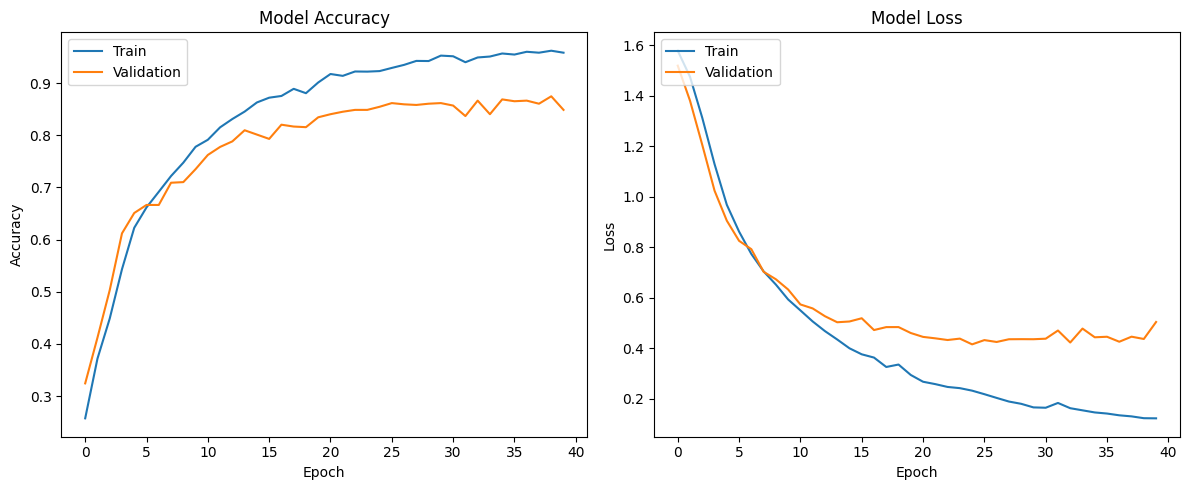

In [25]:

## 6. Visualize Results

# Plot training history and confusion matrices.

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
if 'val_accuracy' in history.history: # Check if validation accuracy exists
    plt.plot(history.history["val_accuracy"])
    plt.legend(["Train", "Validation"], loc="upper left")
else:
    plt.legend(["Train"], loc="upper left")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
if 'val_loss' in history.history: # Check if validation loss exists
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Validation"], loc="upper left")
else:
    plt.legend(["Train"], loc="upper left")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()


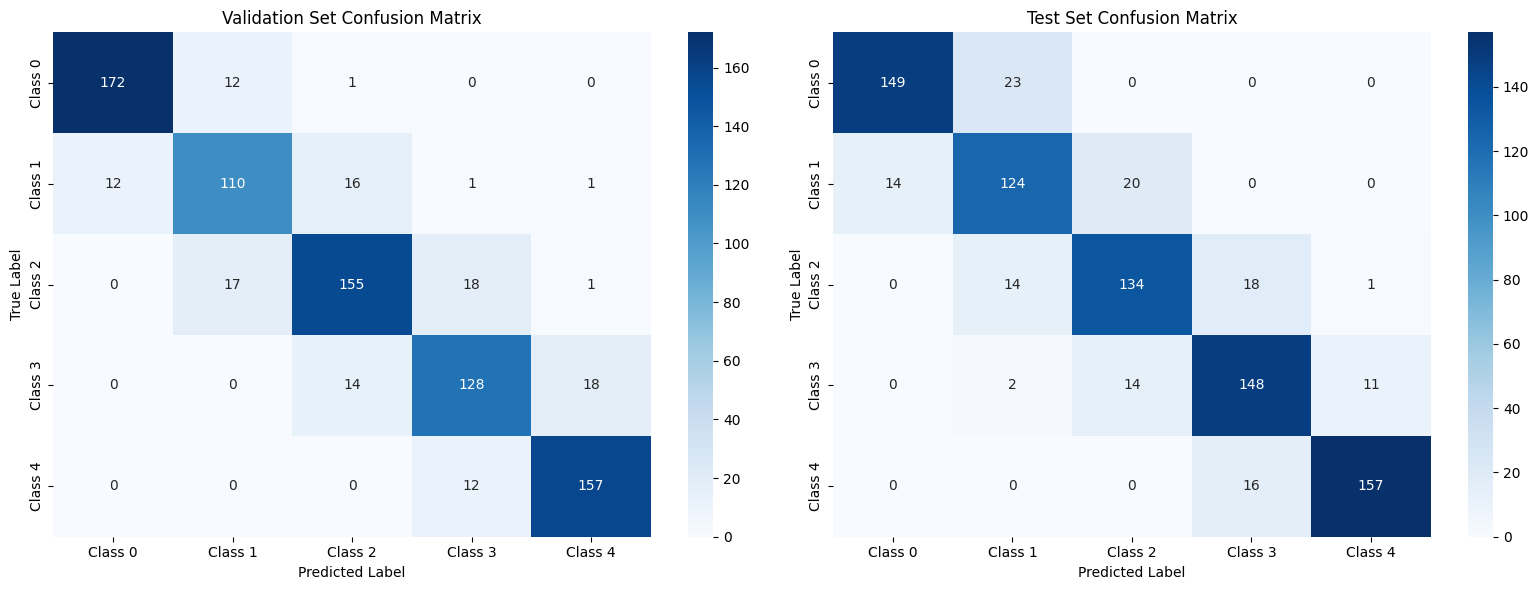

In [26]:

# Plot Confusion Matrix Heatmaps (Validation and Test)
plt.figure(figsize=(16, 6))

# Validation Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {i}" for i in class_names],
            yticklabels=[f"Class {i}" for i in class_names])
plt.title("Validation Set Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# Test Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {i}" for i in class_names],
            yticklabels=[f"Class {i}" for i in class_names])
plt.title("Test Set Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

plt.tight_layout()
plt.show()


In [27]:

# === SUMMARY OF RESULTS ===
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Macro F1 Score: {val_macro_f1:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Macro F1 Score: {macro_f1:.4f}")
print("="*60)

print("\n--- End of Script ---")


FINAL RESULTS SUMMARY
Validation Accuracy: 0.8544
Validation Macro F1 Score: 0.8506
Test Accuracy: 0.8426
Test Macro F1 Score: 0.8419

--- End of Script ---
